In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from numpy import mean, std
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
import pre as pr

In [69]:
from pre import pipeline_completo


In [70]:
resultados = pipeline_completo('cumulative.csv')
X_train = resultados['X_train']
X_test = resultados['X_test']
y_train = resultados['y_train']
y_test = resultados['y_test']
scaler = resultados['scaler']
feature_names = resultados['feature_names']
df_clean = resultados['datos_limpios']


               PIPELINE DE DETECCIÓN DE EXOPLANETAS
Cargando datos...
✓ Datos cargados: 9564 filas, 49 columnas

EXPLORACIÓN INICIAL DE DATOS

1. Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64


✓ Estado final:
   - Filas: 9564, Columnas: 10
   - Valores faltantes restantes: 0

DETECCIÓN DE OUTLIERS

Columna: koi_period
  - Outliers detectados: 1567
  - Ejemplos (máx 10):
24     386.603053
29     670.645531
96     143.206305
166    235.998640
184    119.020704
185    190.320047
214    226.890478
249    105.145959
265     99.641596
312    102.964195

Columna: koi_impact
  - Outliers detectados: 119
  - Ejemplos (máx 10):
14      2.483
203     7.361
267     9.303
332     2.641
636     4.246
719    12.773
766    13.239
845     5.011
925     3.346
945     7.444

Columna: koi_duration
  - Outliers detectados: 869
  - Ejemplos (máx 10):
15     12.2155
29     53.4120
46     14.5610
118    35.5120
185    15.2840
279    16.9422
312    15.7350
318    23.1440
324    38.1939
343    13.5660

Columna: koi_depth
  - Outliers detectados: 1896
  - Ejemplos (máx 10):
2     10829.0
3      8079.2
9      4914.3
10    14231.0
11     6674.7
12     9145.7
14    17984.0
15     8918.7
16    74284.0
17

In [71]:
def RandomForest_trainer(n= 100, md= 20, split= 5, leaf= 2, state= 42, njobs= -1):
    global rf_model

    rf_model = RandomForestClassifier(
    n_estimators=n,
    max_depth=md,
    min_samples_split= split,
    min_samples_leaf= leaf,
    random_state= state,
    n_jobs=njobs
)
    rf_model.fit(X_train,y_train)
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:,1]
    print("\n" + "="*60)
    print("RESULTADOS DEL MODELO")
    print("="*60)
    print(f"\n Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'predictions': y_pred
    }


In [72]:
RandomForest_trainer()


RESULTADOS DEL MODELO

 Accuracy: 0.8996

 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1364
           1       0.81      0.86      0.83       549

    accuracy                           0.90      1913
   macro avg       0.87      0.89      0.88      1913
weighted avg       0.90      0.90      0.90      1913


Confusion Matrix:


{'Accuracy': 0.8996340825927862,
 'confusion_matrix': array([[1250,  114],
        [  78,  471]]),
 'predictions': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,))}

In [73]:
def Evaluation_model (N= 10):
    ''' Implementación de validación cruzada
    Evalua el modelo varias veces'''
    Specificity = make_scorer(recall_score, pos_label=0)


    cross_value_accuracy = RepeatedStratifiedKFold ( n_splits = N, n_repeats=5, random_state=1 ) # Divide los datos en 10 partes, nueve para entrenar 1 para validar. Repite 5 veces con divisiones aleatorias
    n_scores_accuracy = cross_val_score (rf_model, X_test, y_test, scoring = 'accuracy', cv=cross_value_accuracy, 
                                n_jobs =-1, error_score='raise') #
    cross_value_sensitivity = RepeatedStratifiedKFold(n_splits = N, n_repeats=5, random_state=1)
    n_scores_sensititivity = cross_val_score(rf_model, X_test, y_test, scoring='recall', cv=cross_value_sensitivity, 
                                      n_jobs=-1, error_score='raise')
    
    cross_value_specificity = RepeatedStratifiedKFold(n_splits =N, n_repeats=5, random_state=1)
    n_scores_specificity = cross_val_score(rf_model, X_test, y_test, cv=cross_value_specificity, scoring = Specificity,
                                n_jobs=-1, error_score='raise')
    cross_value_precision = RepeatedStratifiedKFold(n_splits =N, n_repeats=5, random_state=1)
    n_scores_precision = cross_val_score(rf_model, X_test, y_test, cv=cross_value_precision, scoring = 'precision' ,
                                n_jobs=-1, error_score='raise')
    cross_value_f1 = RepeatedStratifiedKFold(n_splits =N,  n_repeats=5, random_state=1)
    n_scores_f1 = cross_val_score(rf_model, X_test, y_test, cv=cross_value_f1, scoring = 'f1',
                                n_jobs=-1, error_score='raise')
    #print(n_scores)
    # report performance
    print('Accuracy: %.4f (%.4f)' % (mean(n_scores_accuracy), std(n_scores_accuracy))) #Promedio de las 50 accuracies
    print('sensitivity: %.4f (%.4f)' % (mean(n_scores_sensititivity), std(n_scores_sensititivity)))
    print('specificity: %.4f (%.4f)' % (mean(n_scores_specificity), std(n_scores_specificity)))
    print('precision: %.4f (%.4f)' % (mean(n_scores_precision), std(n_scores_precision)))
    print('f1: %.4f (%.4f)' % (mean(n_scores_f1), std(n_scores_f1)))

        #print(n_scores)
        # report performance
    

In [74]:
Evaluation_model()

Accuracy: 0.8856 (0.0193)
sensitivity: 0.7581 (0.0500)
specificity: 0.9369 (0.0220)
precision: 0.8314 (0.0475)
f1: 0.7916 (0.0354)


In [75]:
def classification_report(y_test, y_pred, positive_label=1):
    tp = fn = fp = tn = 0
    for i, j in zip(y_test, y_pred):
        if i == positive_label:
            if j == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if j == positive_label:
                fp += 1
            else:
                tn += 1
    return tp, fn, fp, tn

def accuracy(tp, fn, fp, tn):
    return (tp + tn) / (tp + fn + fp + tn)

def sensitivity(tp, fn, fp, tn):
    return tp / (tp + fn)

def precision(tp, fn, fp, tn):
    return tp / (tp + fp)

def f1_score(tp, fn, fp, tn):
    prec = precision(tp, fn, fp, tn)
    rec = sensitivity(tp, fn, fp, tn)
    return 2 * (prec * rec) / (prec + rec)

In [76]:
start_time = time.time()

In [77]:
#Print Time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0074617862701416016 seconds ---


In [78]:
def Predictions (X_test):
    y_pred_accuracy = rf_model.predict(X_test)
    print(" Accuracy: {:.3f}%".format(accuracy(*classification_report(y_test, y_pred_accuracy)) * 100))

    y_pred_sensitivity = rf_model.predict(X_test)
    print(" Sensitivity: {:.3f}%".format(sensitivity(*classification_report(y_test, y_pred_sensitivity)) * 100))

    y_pred_precision = rf_model.predict(X_test)
    print(" Precision: {:.3f}%".format(precision(*classification_report(y_test, y_pred_precision)) * 100))

    y_pred_f1 = rf_model.predict(X_test)
    print(" F1 Score: {:.3f}%".format(f1_score(*classification_report(y_test, y_pred_f1)) * 100))
    return {
        'Accuracy': y_pred_accuracy,
        'Sensitivity': y_pred_sensitivity,
        'Precision': y_pred_precision,
        'F1': y_pred_f1
    }

In [79]:
Predictions(X_test)

 Accuracy: 89.963%
 Sensitivity: 85.792%
 Precision: 80.513%
 F1 Score: 83.069%


{'Accuracy': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,)),
 'Sensitivity': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,)),
 'Precision': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,)),
 'F1': array([1, 1, 0, ..., 0, 1, 1], shape=(1913,))}

In [80]:
def Plotting_matrix ():
    y_pred = rf_model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
        cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    #ax.set_title('Confusion Matrix with labels\n\n');
    ax.set_xlabel('Valores preditos pelo modelo')
    ax.set_ylabel('Valores reais ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.savefig('my_plot.JPEG')
    plt.show()

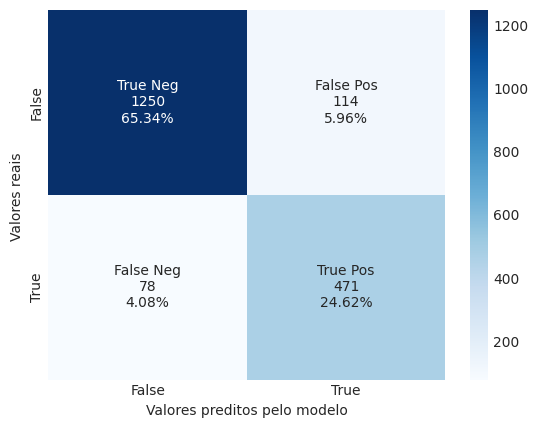

In [81]:
Plotting_matrix()

In [82]:
print (rf_model.feature_importances_)

[0.09632699 0.08949278 0.06579151 0.09079045 0.2038544  0.06035173
 0.05703769 0.27534022 0.02889158 0.03212266]


In [92]:
def find_features_importance(df,threshold = 0.9):
    feat_importances = pd.Series(rf_model.feature_importances_, index=X_test.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()
    print(rf_model.feature_importances_);corrmat = df.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")


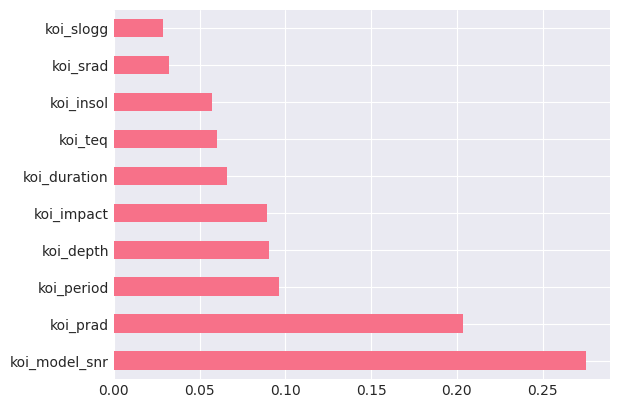

[0.09632699 0.08949278 0.06579151 0.09079045 0.2038544  0.06035173
 0.05703769 0.27534022 0.02889158 0.03212266]


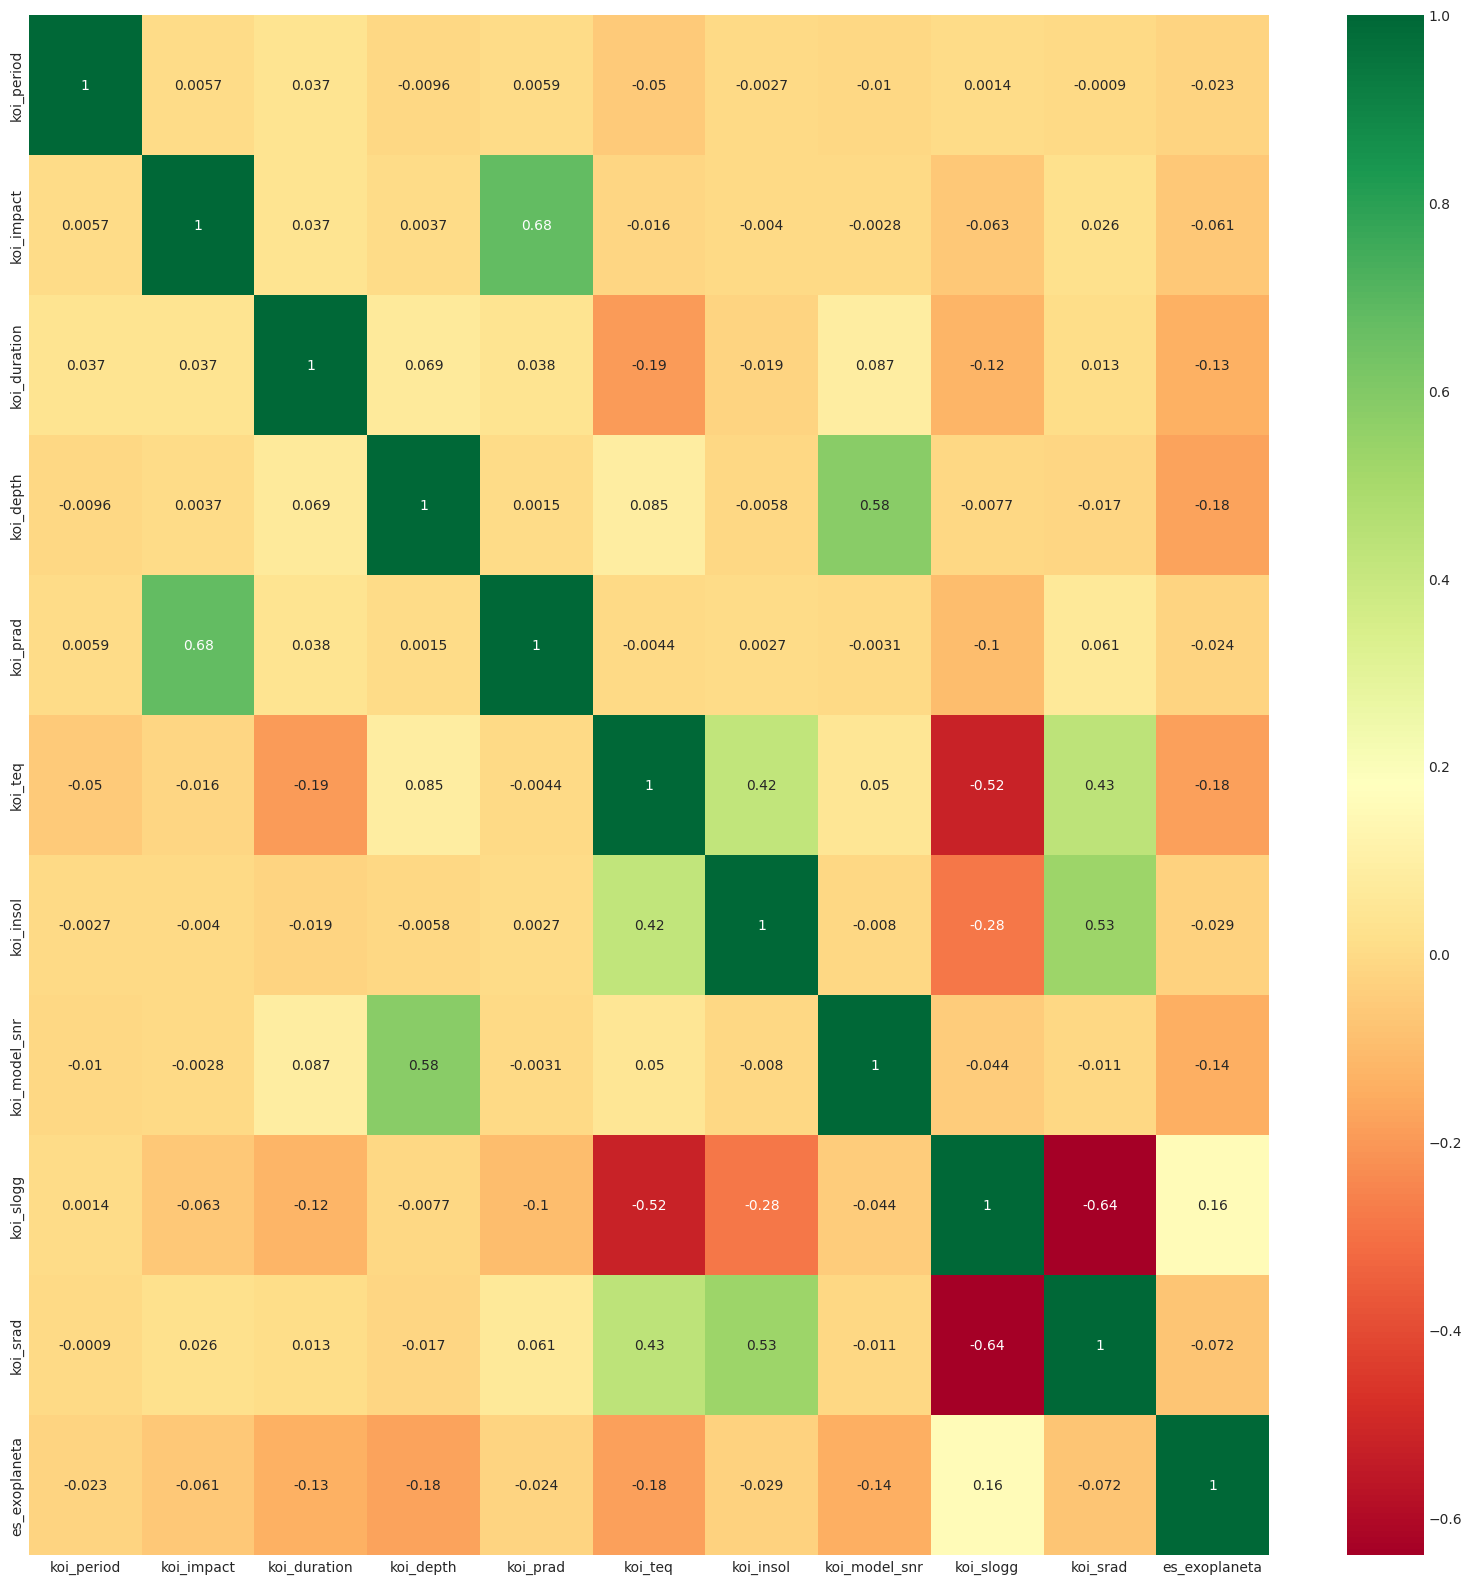

In [93]:
find_features_importance(df_clean)

In [103]:
def plot_dispersion(predictions_dict, y_test):
    # Extract all predictions from the dictionary
    y_pred_accuracy = predictions_dict['Accuracy']
    y_pred_sensitivity = predictions_dict['Sensitivity']
    y_pred_precision = predictions_dict['Precision']
    y_pred_f1 = predictions_dict['F1']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Prediction Dispersion Analysis - All Metrics', fontsize=16, fontweight='bold')
    
    # 1. Accuracy predictions
    axes[0, 0].scatter(y_test, y_pred_accuracy, alpha=0.6, edgecolors='k', linewidth=0.5)
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                     'r--', lw=2, label='Perfect Prediction')
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title('Accuracy Predictions')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Sensitivity predictions
    axes[0, 1].scatter(y_test, y_pred_sensitivity, alpha=0.6, edgecolors='k', linewidth=0.5, color='orange')
    axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                     'r--', lw=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title('Sensitivity Predictions')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision predictions
    axes[1, 0].scatter(y_test, y_pred_precision, alpha=0.6, edgecolors='k', linewidth=0.5, color='green')
    axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                     'r--', lw=2, label='Perfect Prediction')
    axes[1, 0].set_xlabel('Actual Values')
    axes[1, 0].set_ylabel('Predicted Values')
    axes[1, 0].set_title('Precision Predictions')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. F1 predictions
    axes[1, 1].scatter(y_test, y_pred_f1, alpha=0.6, edgecolors='k', linewidth=0.5, color='purple')
    axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                     'r--', lw=2, label='Perfect Prediction')
    axes[1, 1].set_xlabel('Actual Values')
    axes[1, 1].set_ylabel('Predicted Values')
    axes[1, 1].set_title('F1 Predictions')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()




 Accuracy: 89.963%
 Sensitivity: 85.792%
 Precision: 80.513%
 F1 Score: 83.069%


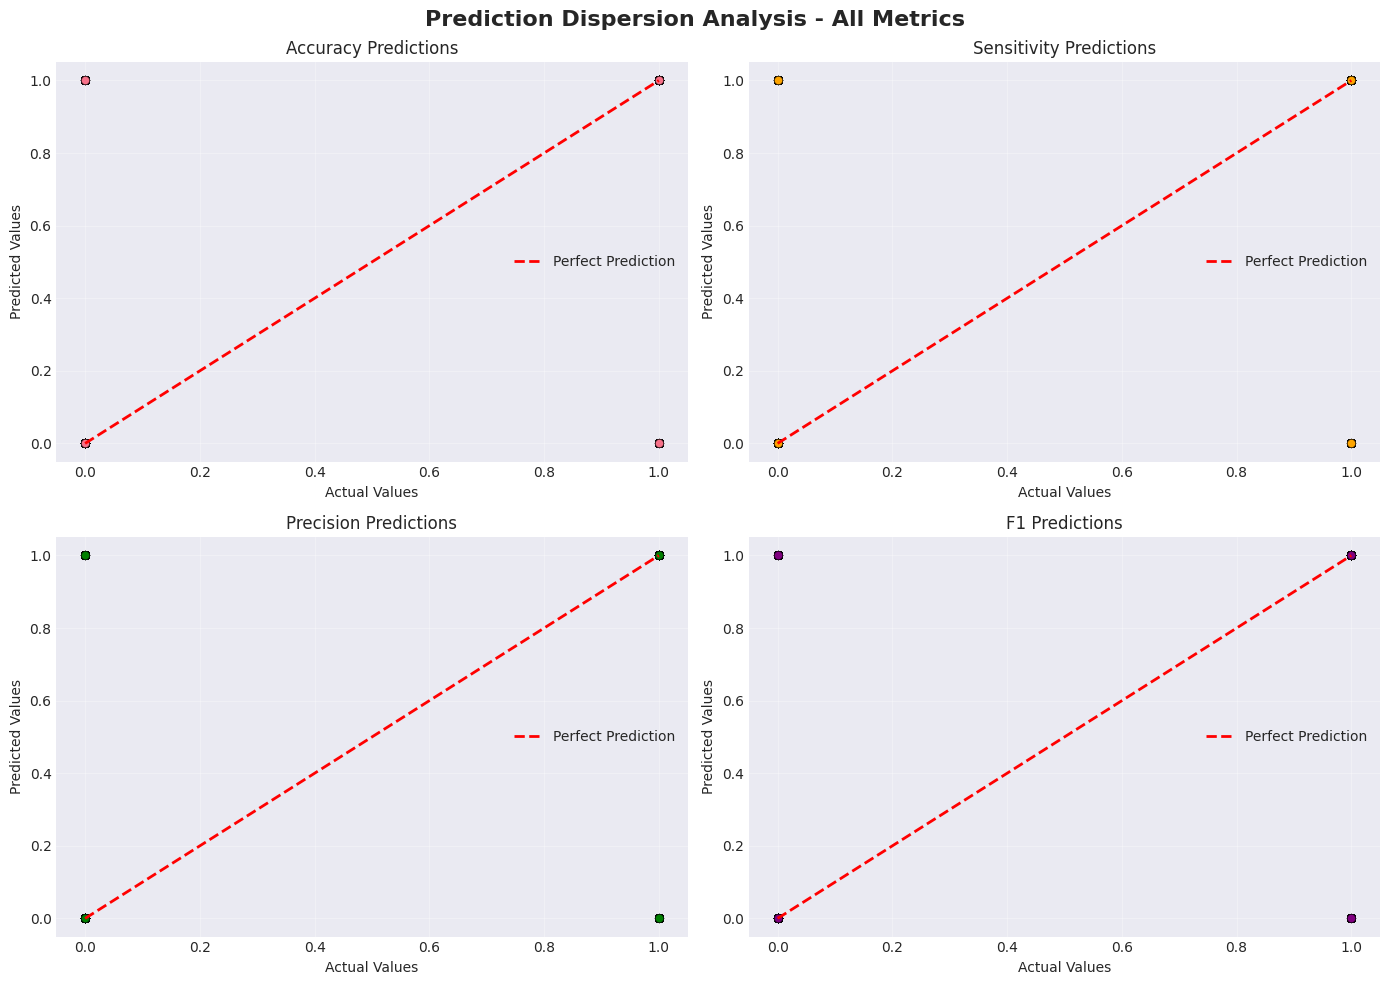

In [104]:
# Usage:
predictions = Predictions(X_test)
plot_dispersion(predictions, y_test)